<font size="6">Fractional Maximum Likelihood Estimation</font>

TBD

<font size="5">Purpose</font>

Fractional MLE

<font size="5">Method</font>

TBD

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

In [2]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets. We end up with a 3-dimensional multivariate gaussian system. 

In [3]:
m6 = pd.read_csv('./data/assets_m6_2022.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Z-Scoring & Auto-Correlation Decay Plots</font>

Formatting the training data. There is only training data and no test data in this exercise (it is a purely descriptive exercise). Z-scored measurements of the log price for each asset based on a rolling window. At timepoint 't' the window looks back 'w' steps to calculate mu and sigma. 

$$\huge z_t = \frac{x_t - \mu_{t-w:t}}{\sigma_{t-w:t}}$$

There are regions where the current log price is either above or below its running average (as measured in units of standard deviation) and this formatting of the data preserves long memory based on looking at the auto-correlation decay plots. <b>It is important that the running average never takes into account future data which would introduce lookahead bias, so a rolling metric based on the list comprehension is used.</b> 

The ACF function is defined as follows, 

$$ \huge \operatorname{ACF}(\tau) = \frac{\sum_{t=1}^{n-\tau} (x_t - \bar{x})(x_{t+\tau} - \bar{x})}{\sum_{t=1}^n (x_t - \bar{x})^2} $$

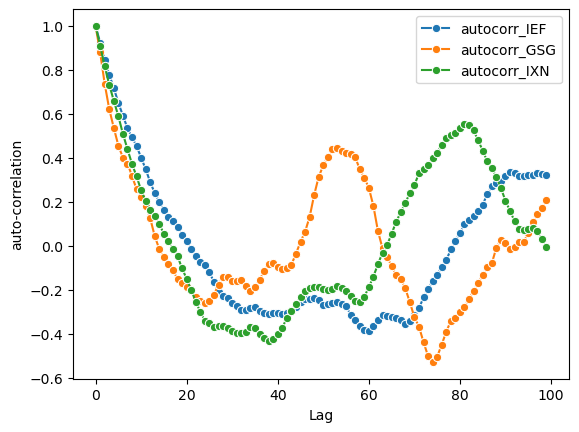

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-__pakz6t
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-__pakz6t
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Empirical Mean: -0.010449104313267236
Empirical Variance: 1.4044892048506201
Empirical Hurst: 0.9254364233248571
Estimated Mean: 0.0006533598175810229
Estimated Variance: 0.9947335549462328
Estimated Auto-covariance:
 [[1.4044892  1.3932235  0.12740786 ... 0.06165958 0.06304782 0.21085989]
 [1.3932235  1.4044892  0.1485723  ... 0.0725329  0.07414899 0.24387463]
 [0.12740786 0.1485723  1.4044892  ... 1.20365715 1.21397753 1.28937688]
 ...
 [0.06165958 

In [10]:
import scipy.stats as stats
import scipy 

m6_subset1 = m6_assets.copy()

# Window length 25 days
wlen = 25

# First convert to log price 
m6_subset1 = m6_subset1.apply(np.log)

# Clean data
m6_subset1 = m6_subset1.dropna().reset_index().drop(columns='index')

# Apply z-score in a rolling way that does not create lookahead bias 
rolling_zscore = lambda serie: [ stats.zscore(serie[x-wlen:x]).values[-1] for x in range(wlen, len(serie) + 1) ]

m6_subset = pd.DataFrame()
m6_subset['IEF'] = rolling_zscore(m6_subset1['IEF'])
m6_subset['GSG'] = rolling_zscore(m6_subset1['GSG'])
m6_subset['IXN'] = rolling_zscore(m6_subset1['IXN'])

# View Auto Correlation
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, 100)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, 100)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, 100)), label='autocorr_IXN', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()

%pip install torch
%pip install gpytorch
%pip install git+https://github.com/forrestbao/pyeeg.git
import torch
import gpytorch
import pyeeg

class FractionalMLE:
    def __init__(self, data):
        self.data = np.array(data)
        self.n = len(data)
        self.mean = None
        self.variance = None
        self.auto_covariance = None
    
    def log_likelihood(self, mean=0., var=1.):
        # Eigenvalues for power spectrum analysis 
        def compute_eigensamples(x):  
            
            # Fit kernel
            kernel = gpytorch.kernels.MaternKernel(lengthscale=0.1)
            kernel_autocov = kernel(torch.tensor(x).unsqueeze(1)).evaluate()

            # Compute the auto-covariance matrix using the RBFKernel
            self.auto_covariance = (kernel_autocov * var).detach().numpy()

            # Add a small positive constant to the diagonal of the matrix
            j = 1e-7
            C = self.auto_covariance + (j * np.eye(len(x)))
            
            # Compute eigenvalues of the auto-correlation matrix
            eigenvalues = np.linalg.eigvalsh(C)

            # Normalize the eigenvalues
            normalized_eigenvalues = eigenvalues / np.sum(eigenvalues)

            # Generate random samples from the exponential distribution
            samples = []
            for eigenvalue in normalized_eigenvalues:
                rate = 1.0 / eigenvalue
                sample = stats.expon.rvs(scale=rate)
                samples.append(sample)
                
            return samples, C
        
        # Parameters
        self.log_likelihood = 0.
        self.mean = 0.
        self.variance = 0.
        self.hurst = 0.5
        
        # Iterations
        iters = 30
        
        # Get eigenvectors
        eigensamples, C = compute_eigensamples(self.data)
        
        # Cholesky decomposition
        L = np.linalg.cholesky(C)          
    
        # Run synthetic data generating process
        for i in range(1, iters): 
            
            # Generate a random vector
            z = np.random.normal(loc=mean, size=len(self.data)) 
            
            # Multiply L by z to get cholesky-adjusted data 
            LLz = np.dot(L, z) 

            # likelihood of the data given the parameters of the eigenvalue dist 
            self.log_likelihood = \
                self.log_likelihood + np.log(np.mean( \
                    stats.expon.pdf(compute_eigensamples(LLz)[0], \
                                        loc=np.mean(eigensamples), scale=np.std(eigensamples)
                                    ))
                                )
            
            # Compute average parameters
            self.mean = self.mean + np.mean(LLz) 
            self.variance = self.variance + np.var(LLz) 
            self.hurst = self.hurst + pyeeg.hurst(LLz)
        
        # Ensemble average params including average log likelihood 
        self.variance = self.variance / iters
        
        # Return log likelihood
        self.mean = self.mean / iters
        self.hurst = self.hurst / iters
        self.log_likelihood = self.log_likelihood / iters 
        return self.log_likelihood
        
# Example usage
data = m6_subset['GSG'].values
fractional_mle = FractionalMLE(data)
fractional_mle.log_likelihood(np.mean(fractional_mle.data), var=np.var(fractional_mle.data))

print("Empirical Mean:", np.mean(fractional_mle.data))
print("Empirical Variance:", np.var(fractional_mle.data))
print("Empirical Hurst:", pyeeg.hurst(fractional_mle.data))

print("Estimated Mean:", fractional_mle.mean)
print("Estimated Variance:", fractional_mle.variance)
print("Estimated Auto-covariance:\n", fractional_mle.auto_covariance)
print("Estimated Hurst:", fractional_mle.hurst)

print("Estimated Log Likelihood:", fractional_mle.log_likelihood)


Instantiate a non-parametric model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the final state the system lands on, states[-1]. 

In [5]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process', 
                                          n_init=10, 
                                          max_iter=1000)

In [6]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

# Count the frequency of each latent state 
state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

<font size=5> Precision Matrices Graph </font>

Note: you may need to restart the kernel to use updated packages.


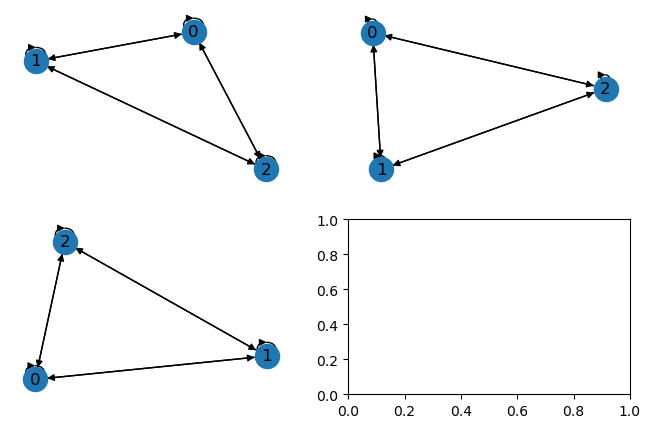

In [7]:
%pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(2, 2, figsize=(8, 5))

i = 0
j = 0 
for pmat in dpgmm_model.precisions_:
    if state_counts[i] > 0: 
        ax = axes[j//2][j%2]
        G = nx.DiGraph(pmat)
        nx.draw(G, with_labels=True, ax=ax)
        j += 1
    i += 1

plt.show()